In [48]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd

In [49]:
dir0 = Path('el_nino/')
file_sst = 'sst.mnmean.nc'
file_2 = 'mslp_coarse.nc'

# load the data set with xarray
ds_nino = xr.open_dataset(Path(dir0, file_sst))
ds = xr.open_dataset(Path(dir0, file_2))
# print(ds.head())

In [50]:
# delete the first month so that the 3-month average looks better
start_date = pd.to_datetime('1981-12-01')
end_date = pd.to_datetime('1981-12-31')

ds_filtered = ds_nino.where(~((ds_nino.time >= start_date) & (ds_nino.time <= end_date)), drop=True)

# interpolate the NaN values
ds_filtered = ds_filtered.interpolate_na(dim='lon')

# Resample and compute the mean for each 3-month period
ds_3m = ds_filtered.resample(time='3M').mean()
# print(ds_3m)

In [74]:
# define 3.4 region
lat_min, lat_max = -5.5, 5.5
lon_min, lon_max = 190, 240

# Select the region
ds_region = ds_3m.where((ds_3m.lat >= lat_min) & (ds_3m.lat <= lat_max) & (ds_3m.lon >= lon_min) & (ds_3m.lon <= lon_max), drop=True)

# Compute the mean over the selected region
region_mean = ds_region['sst'].mean(dim=['lat', 'lon'])
# print(region_mean)

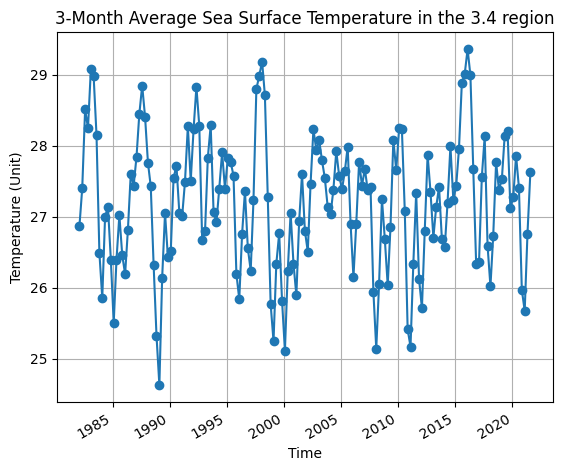

In [52]:
# Plotting
region_mean.plot.line(x='time', marker='o')

# Enhancing the plot
plt.title('3-Month Average Sea Surface Temperature in the 3.4 region')
plt.xlabel('Time')
plt.ylabel('Temperature (Unit)')  # Replace 'Unit' with the actual unit of your data
plt.grid(True)
plt.show()

In [60]:
# labeling the data


# List of years when El Niño occurred
elnino_years = [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2015, 2018]
lanina_years = [1983, 1984, 1988, 1995, 1998, 1999, 2000, 2005, 2007, 2008, 2010, 2016, 2017, 2020, 2021]

# Create a range of years from 1981 to current year
years = range(1982, 2022)

# Create a DataFrame
df = pd.DataFrame({
    'Year': years,
    'El_Nino': [1 if year in elnino_years else -1 if year in lanina_years else 0 for year in years]
})

# print(df)

In [121]:
# make points for each year with the label of el nino or la nina
# trying to predict for a given year with the data from the year before

years2 = range(1983, 2021)

# Prepare lists to store data
years_col = []
el_nino_col = []
sst_data = {}

# Loop through each year
for year in years2:
    years_col.append(year)
    el_nino_col.append(1 if year in elnino_years else -1 if year in lanina_years else 0)
    
    # flatten the sst from ds_region
    filtered_data = ds_region.where(ds_region['time'].dt.year == (year - 1), drop=True)
    numpy_array = filtered_data['sst'].to_numpy()
    flattened_data = numpy_array.flatten()
    sst_data[str(year)] = flattened_data

# Convert the dictionary to a 2D NumPy array
sst_array = np.array(list(sst_data.values()))

# Convert el_nino_col to a NumPy array
labels = np.array(el_nino_col)

print(sst_array.shape)
print(labels.shape)


(38, 2400)
(38,)


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(sst_array, labels, test_size=0.2, random_state=42)

# Create the SVM model with a kernel
svm_model = SVC(kernel='rbf')

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.25
